In [1]:
import sys
import numpy as np
import pystellibs
import matplotlib.pyplot as plt

In [2]:
sys.path.append("dev/")
from dev.data import PhotData
from dev.base import PhotometryPipeline
from dev.star_cluster import StarCluster
from dev.parsec_isochrones import Parsec
from dev.photometry import Photometry
from dev.spectral_interpolator import SpectrumGenerator
from dev.dustmap_handler import DustMap

In [3]:
# from astropy import units as u
# from pyphot import unit
# x = np.arange(0, 11) * u.km
# x.to(u.cm).value
# unit['angstrom']

In [118]:
parsec_folder_path = '/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/isochrone_files/gaia_phot'
map_fpath = '/Users/ratzenboe/Documents/work/data_local/dustmap_data/'

star_cluster_kwargs = dict(
    mu=np.array([100, 0, 0, 10, 10, 10]),
    cov=np.diag([1, 1, 1, 1, 1, 1]),
    cluster_mass=1e3,
    logAge=6.0,
    Z=0.0125
)

phpipe = PhotometryPipeline(steps=[
    ('cluster', StarCluster(**star_cluster_kwargs)),
    ('parsec_isochrones', Parsec(parsec_folder_path)),
    ('dustmap', DustMap('edenhofer', map_fpath)),
    # BT-Settl and BaSeL models seem to reproduce more or less the Parsec isochrone model results.
    # The BaSeL models seem to approximate the behavior better at the redder, faint end
    ('spectrum', SpectrumGenerator(stellib=pystellibs.BTSettl())),
    ('filter', Photometry(filter_names=["GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'irac']))
])

PARSEC isochrones read and processed!


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


In [119]:
data = PhotData()
data.Rv = 3.1

phpipe.set_params(
    cluster__mu=np.array([1000, 0, 0, 10, 10, 10]),    # <-- update cluster center
    # spectrum__stellib=pystellibs.BTSettl(),             # <-- update stellar library models
    # dustmap__dustmap='planck',                        # <-- use Planck dustmap
)
data = phpipe.run(data)

Total cluster mass is 1000.09 (limit was 1000)
Generating spectra for 1781 sources (out of 2647)


/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_63823/2331817433.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cl, flx[idx], s=100, marker='x', c=colors[i], label=f'{b}', lw=3, alpha=0.8, zorder=10)


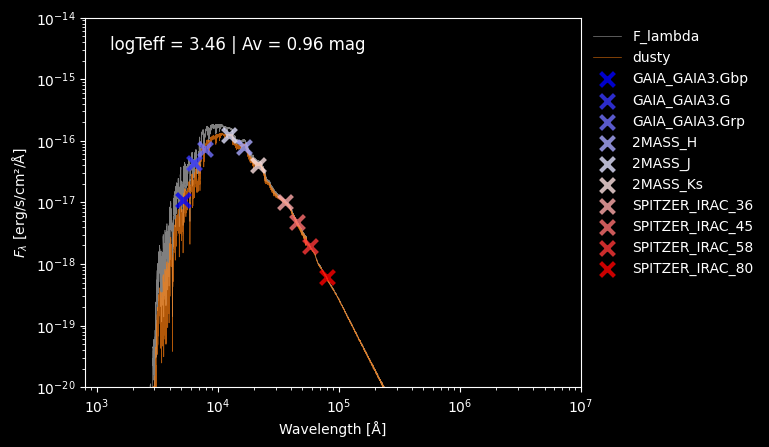

In [121]:
idx = 1000

# Black background, white grid
plt.style.use('dark_background')
plt.loglog(data.wavelength, data.flam[idx], lw=0.5, label='F_lambda', color='tab:grey',alpha=1)
plt.loglog(data.wavelength, data.flam_dusty[idx], lw=0.5, label='dusty', color='tab:orange', alpha=0.7)

# create 10 different colors
colors = plt.cm.bwr(np.linspace(0, 1, len(data.flam_band)))

for i, (b, flx) in enumerate(data.flam_band.items()):
    cl = data.cl_band[b]
    # Plot the band
    plt.scatter(cl, flx[idx], s=100, marker='x', c=colors[i], label=f'{b}', lw=3, alpha=0.8, zorder=10)
    # Compute the magnitudes

# Write Av to left upper corner
plt.annotate(
    f'logTeff = {data.logT[idx]:.2f} | Av = {data.Av[idx]:.2f} mag ',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    fontsize=12,
    ha='left',
    va='top',
)

plt.xlim(800, 1e7)
plt.ylim(1e-20, 1e-14)
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'$F_{\lambda}$ [erg/s/cm²/Å]')
# put legend outside
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('/Users/ratzenboe/Desktop/plts/test_spectral_library_no_phot_phot_bands.png', dpi=300, bbox_inches='tight', )

# Plot CMD

In [122]:
# Compute CMD
is_alive = data.is_alive
gaia_bp = data.mag_band['GAIA_GAIA3.Gbp'][is_alive].value
gaia_rp = data.mag_band['GAIA_GAIA3.Grp'][is_alive].value
gaia_g = data.mag_band['GAIA_GAIA3.G'][is_alive].value
d_pc = data.distance[is_alive].value

In [123]:
# Compute absolute G magnitude
M_G = gaia_g - 5 * np.log10(d_pc/10)
bp_rp = gaia_bp - gaia_rp

In [124]:
# Test against Parsec isochrones
# Add path to isochrone scripts
import os
import sys
sys.path.append('/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/modules')
from isochrone_base import ParsecGaia


def gaia_extinction(A_V, M_G, G_BP, G_RP):
    """Apply extinction to individual isochrone"""
    # Define extinction correction coefficients
    corr_Gmag = 0.83627
    corr_BPmag = 1.08337
    corr_RPmag = 0.63439
    # Compute extincted magnitudes
    M_G_ext = M_G + A_V * corr_Gmag
    G_BP_ext = G_BP + A_V * corr_BPmag
    G_RP_ext = G_RP + A_V * corr_RPmag
    return M_G_ext, G_BP_ext, G_RP_ext


Text(0, 0.5, 'M_G')

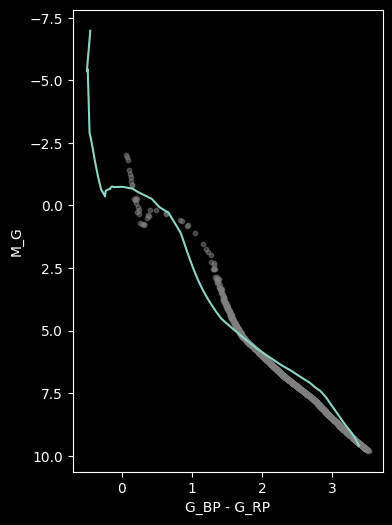

In [125]:
plt.figure(figsize=(4, 6))
plt.scatter(bp_rp, M_G, s=10, c='tab:grey', alpha=0.5)
plt.plot(df_p_gaia.G_BP - df_p_gaia.G_RP, df_p_gaia.M_G)
# invert y axis
plt.gca().invert_yaxis()
plt.xlabel('G_BP - G_RP')
plt.ylabel('M_G')

In [126]:
p_gaia_obj = ParsecGaia(parsec_folder_path)
df_p_gaia = p_gaia_obj.query_cmd(
    data.mass, data.logAge, np.ones_like(data.mass)*phpipe.get_step('parsec_isochrones').feh_from_z(0.0125)
)
# Apply extinction
A_V = data.Av
M_G_ext, G_BP_ext, G_RP_ext = gaia_extinction(A_V, df_p_gaia.M_G, df_p_gaia.G_BP, df_p_gaia.G_RP)

PARSEC isochrones read and processed!


# Test against Parsec isochrones

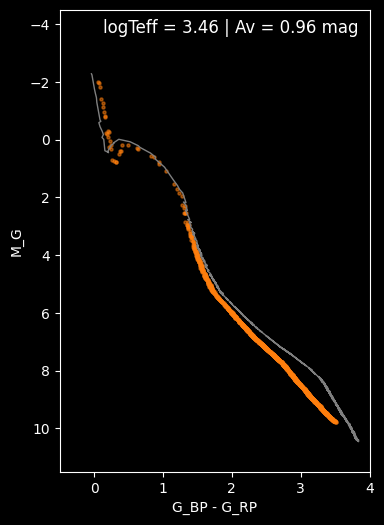

In [127]:
plt.figure(figsize=(4, 6))
plt.scatter(bp_rp, M_G, s=5, c='tab:orange', alpha=0.5)
plt.plot(G_BP_ext - G_RP_ext, M_G_ext, ls='-', lw=1, color='tab:grey', label='Parsec Isochrones')
# invert y axis
plt.gca().invert_yaxis()
plt.xlabel('G_BP - G_RP')
plt.ylabel('M_G')
plt.annotate(
    f'logTeff = {data.logT[idx]:.2f} | Av = {data.Av[idx]:.2f} mag ',
    xy=(0.98, 0.98),
    xycoords='axes fraction',
    fontsize=12,
    ha='right',
    va='top',)

plt.xlim(-0.5, 4)
plt.ylim(11.5, -4.5)
plt.savefig('/Users/ratzenboe/Desktop/plts/test_spectral_library_cmd_basel.png', dpi=300, bbox_inches='tight')